In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

claims = pd.read_csv('cleaned_claims.csv')
rtw = pd.read_csv('cleaned_rtw.csv')
comp = pd.read_csv('cleaned_comp.csv')
services = pd.read_csv('cleaned_services.csv')
billing = pd.read_csv('cleaned_billing.csv')



In [37]:
#to check if the title  case has been applied and if column types are correct
print(rtw['job_role'].unique())

rtw.info()

['Nurse' 'Labourer' 'Electrician' 'Call Centre Agent'
 'Office Administrator' 'Warehouse Operator' 'Retail Assistant'
 'Project Manager' 'Support Worker' 'Truck Driver']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   claim_id       3000 non-null   object
 1   days_off_work  3000 non-null   int64 
 2   rtw_status     3000 non-null   object
 3   company_name   3000 non-null   object
 4   job_role       3000 non-null   object
dtypes: int64(1), object(4)
memory usage: 117.3+ KB


In [38]:
#merging claims and rtw tables

#stats on days off of work 
claims_rtw = claims.merge(rtw, on ='claim_id', how = 'inner')
print("Days off Work")
print(claims_rtw['days_off_work'].describe())

#identify long tail claims

threshold_90 = claims_rtw['days_off_work'].quantile(0.90)
long_tail =claims_rtw[claims_rtw['days_off_work']>=threshold_90] 

print(f'\n 90th Percentile : {threshold_90:0.2f} days')
print (f'Number of long tail claims: {len(long_tail)} claims')


Days off Work
count    3000.000000
mean       45.745333
std        42.797566
min         1.000000
25%        19.000000
50%        34.000000
75%        58.000000
max       464.000000
Name: days_off_work, dtype: float64

 90th Percentile : 93.00 days
Number of long tail claims: 306 claims


In [39]:
# return to work status of the workers 
print((claims_rtw['rtw_status']
      .value_counts(normalize=True)*100)
      .round(2)
      .astype(str) +"%")


rtw_status
Full             55.7%
Partial         35.43%
Not Returned     8.87%
Name: proportion, dtype: object


In [40]:
#stratify by different groups

#avg days off by injury type
injury_avg = claims_rtw.groupby('injury_type')['days_off_work'].agg(['mean','median','count']).round(2)
print(injury_avg.sort_values('mean', ascending = False))

                  mean  median  count
injury_type                          
Soft Tissue      48.95    33.0    310
Musculoskeletal  46.24    34.0   1340
Fracture         45.31    34.0    451
Other            44.69    31.0    298
Psychological    43.83    33.0    601


In [41]:
#avg days off by Age group
claims_rtw['age_group'] = pd.cut(claims_rtw['worker_age'],
                                 bins = [18,25,35,45,55,65,75],
                                 labels = ['18-25','25-35','35-45','45-55','55-65','65-75'])

age_avg = claims_rtw.groupby('age_group', observed = False)['days_off_work'].agg(['mean','median','count']).round(2)
print(age_avg.sort_values('age_group', ascending = True))
      

            mean  median  count
age_group                      
18-25      46.53    39.0    143
25-35      46.94    35.0    702
35-45      45.64    33.0   1124
45-55      44.28    33.0    759
55-65      49.27    34.0    203
65-75      40.85    32.0     33


In [42]:
#avg days off by job

job_avg = claims_rtw.groupby('job_role')['days_off_work'].agg(['mean', 'median','count']).round(2)
print(job_avg.sort_values('job_role', ascending = True))


                       mean  median  count
job_role                                  
Call Centre Agent     45.20    34.0    256
Electrician           43.61    35.0    209
Labourer              41.53    30.0    508
Nurse                 50.21    35.5    288
Office Administrator  47.52    33.0    346
Project Manager       48.75    37.0    173
Retail Assistant      47.90    35.0    299
Support Worker        45.68    35.0    257
Truck Driver          48.86    36.0    320
Warehouse Operator    41.93    32.0    344


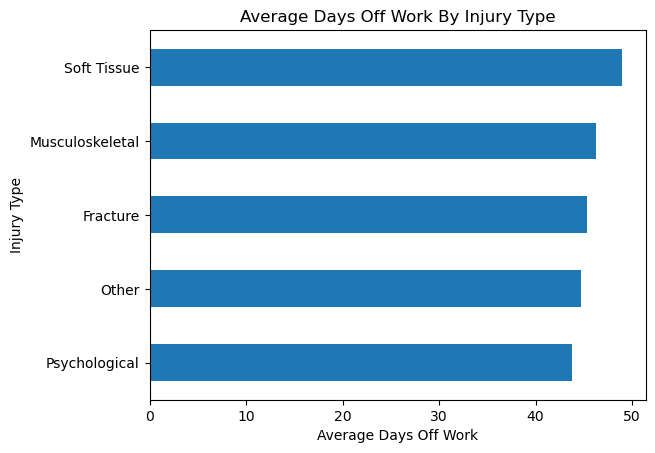

In [43]:
#Visualising days off of work by injury type
injury_avg = claims_rtw.groupby('injury_type')['days_off_work'].mean()
injury_avg.sort_values().plot(kind = 'barh')

plt.xlabel("Average Days Off Work")
plt.ylabel("Injury Type")
plt.title("Average Days Off Work By Injury Type")
plt.show()

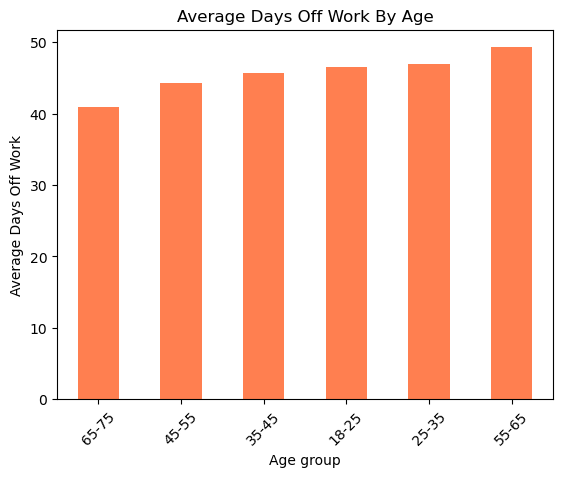

In [44]:
#Visualising days off of work by age 

age_avg =  claims_rtw.groupby('age_group', observed = False)['days_off_work'].mean()
age_avg.sort_values().plot(kind = 'bar', color ='coral')

plt.xlabel("Age group")
plt.xticks(rotation = 45)
plt.ylabel("Average Days Off Work")
plt.title("Average Days Off Work By Age")
plt.show()

In [45]:
#does different injury lead to differen recovery times  - One way ANOVA
# null hypothesis : all injury have same aveage days off of work
#alternate hypothesis : Recovery time differsb based on injury 
from scipy.stats import f_oneway
claims_rtw.groupby('injury_type')['days_off_work'].mean().sort_values()
f_stats, p_value = f_oneway(
    *[g['days_off_work'] for _, g in claims_rtw.groupby('injury_type')]
)
print("P-value:", round(p_value,4))

if p_value<0.05 : 
    print("Recovery time differs by injury type")
else:
    print("No clear difference in recovery time")

# as per results below, no statistical difference in recovery time across injury based on injury, suggesting that RTW outcomes
#can be influenced by demographic or interventional related factors rahter than injury classification alone


P-value: 0.5007
No clear difference in recovery time


In [46]:
#correlation between age and days off of work 
from scipy.stats import pearsonr
correlation, p_value = pearsonr(claims_rtw['worker_age'], claims_rtw['days_off_work'])
print(f"Correlation coefficient :{correlation:0.3f}")
print(f"P-value:{p_value: 0.3f}")

#as per result below correlation coefficient is close to 0 hence no linear relation between worker age and days off
#p-value is higher than 0.05 - which means the result is not satistically significant -i.e worker age is not a risk factor for claim duration


Correlation coefficient :-0.012
P-value: 0.523


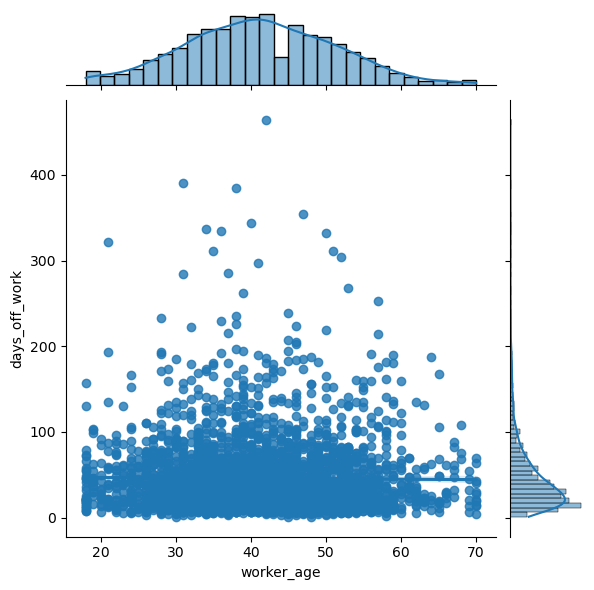

In [47]:

sns.jointplot(data=claims_rtw, x='worker_age', y='days_off_work', kind='reg')
plt.show()

In [57]:
#merging compensation sheet and billing sheet

comp_billing = pd.merge(comp,billing, on="claim_id", how ='inner')
print(comp_billing.info())
print(comp_billing.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8882 entries, 0 to 8881
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   claim_id                   8882 non-null   object 
 1   total_income_support_paid  8882 non-null   float64
 2   impairment_percentage      8882 non-null   float64
 3   medical_expenses           8882 non-null   float64
 4   legal_costs                8882 non-null   float64
 5   return_to_work_costs       8882 non-null   float64
 6   invoice_amount             8882 non-null   float64
 7   paid_status                8882 non-null   object 
 8   days_to_pay                8882 non-null   float64
 9   policy_name                8882 non-null   object 
dtypes: float64(7), object(3)
memory usage: 694.0+ KB
None
Index(['claim_id', 'total_income_support_paid', 'impairment_percentage',
       'medical_expenses', 'legal_costs', 'return_to_work_costs',
       'invoice_amount'

In [58]:
#calculating total claim costs

comp_billing['total_claim_cost']= comp_billing['total_income_support_paid']
+comp_billing['medical_expenses']+comp_billing['legal_costs']+comp_billing['return_to_work_costs']+comp_billing['invoice_amount']
print(comp_billing['total_claim_cost'])

0       82452.68
1        8272.96
2        8272.96
3        1638.09
4        1638.09
          ...   
8877     4829.73
8878     4829.73
8879     4829.73
8880     5446.31
8881     5446.31
Name: total_claim_cost, Length: 8882, dtype: float64


In [59]:
#outlier detection and removal
original_count = len(comp_billing)
Q1 = comp_billing['total_claim_cost'].quantile(0.25)
Q3 = comp_billing['total_claim_cost'].quantile(0.75)

IQR = Q3-Q1

lower = Q1 -(1.5*IQR)
upper = Q3 + (1.5*IQR)

comp_billing = comp_billing[comp_billing['total_claim_cost'].between(lower, upper)].copy()

new_count = len(comp_billing)

print("Removed %d outlier claims." %(original_count-new_count))

Removed 570 outlier claims.


In [60]:
comp_billing[['medical_expenses','legal_costs','return_to_work_costs','invoice_amount','total_claim_cost']].describe().round(2)

,medical_expenses,legal_costs,return_to_work_costs,invoice_amount,total_claim_cost
count,8312.00,8312.00,8312.00,8312.00,8312.00
mean,9019.47,3308.57,4055.29,4402.27,8638.63
std,9897.22,11057.50,4917.93,2419.54,6100.26
min,199.75,0.00,0.00,205.58,180.23
25%,3286.16,0.00,0.00,2383.10,3977.33
50%,5902.12,0.00,1176.01,4394.96,7058.15
75%,11281.54,0.00,8055.61,6299.64,11799.06
max,142368.01,59959.97,14997.33,11962.35,27706.72


In [61]:
# finding high risk claims

threshold = comp_billing['total_claim_cost'] .quantile(0.75)

comp_billing['claim_risk'] = np.where(comp_billing['total_claim_cost'] >= threshold, 
                                     'high risk', 'low risk')

 

In [62]:
print((comp_billing['claim_risk'].value_counts(normalize = True)*100)
.round(2)
.astype(str)+'%')

claim_risk
low risk     74.99%
high risk    25.01%
Name: proportion, dtype: object


In [63]:
comp_billing_rtw = pd.merge(comp_billing,rtw, on='claim_id', how = 'inner' )
print(comp_billing_rtw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8312 entries, 0 to 8311
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   claim_id                   8312 non-null   object 
 1   total_income_support_paid  8312 non-null   float64
 2   impairment_percentage      8312 non-null   float64
 3   medical_expenses           8312 non-null   float64
 4   legal_costs                8312 non-null   float64
 5   return_to_work_costs       8312 non-null   float64
 6   invoice_amount             8312 non-null   float64
 7   paid_status                8312 non-null   object 
 8   days_to_pay                8312 non-null   float64
 9   policy_name                8312 non-null   object 
 10  total_claim_cost           8312 non-null   float64
 11  claim_risk                 8312 non-null   object 
 12  days_off_work              8312 non-null   int64  
 13  rtw_status                 8312 non-null   objec

In [64]:
severity_by_job = (comp_billing_rtw.groupby(['job_role','claim_risk'], observed= False)
                   .size()
                   .unstack(fill_value = 0))

severity_by_job = severity_by_job.sort_values(by = 'high risk', ascending = False)
print(severity_by_job)

claim_risk            high risk  low risk
job_role                                 
Labourer                    358      1078
Office Administrator        250       701
Warehouse Operator          232       732
Retail Assistant            219       623
Nurse                       204       584
Truck Driver                194       687
Support Worker              190       521
Call Centre Agent           172       521
Electrician                 147       419
Project Manager             113       367


In [65]:
#finding the risk ratio based on job roles

severity_by_job['total'] = severity_by_job['high risk'] + severity_by_job['low risk']

severity_by_job['risk ratio'] = severity_by_job['high risk'] /severity_by_job['total']
severity_by_job.round(2).sort_values(by = 'high risk', ascending = False)

claim_risk,high risk,low risk,total,risk ratio
job_role,,,,
Labourer,358,1078,1436,0.25
Office Administrator,250,701,951,0.26
Warehouse Operator,232,732,964,0.24
Retail Assistant,219,623,842,0.26
Nurse,204,584,788,0.26
Truck Driver,194,687,881,0.22
Support Worker,190,521,711,0.27
Call Centre Agent,172,521,693,0.25
Electrician,147,419,566,0.26


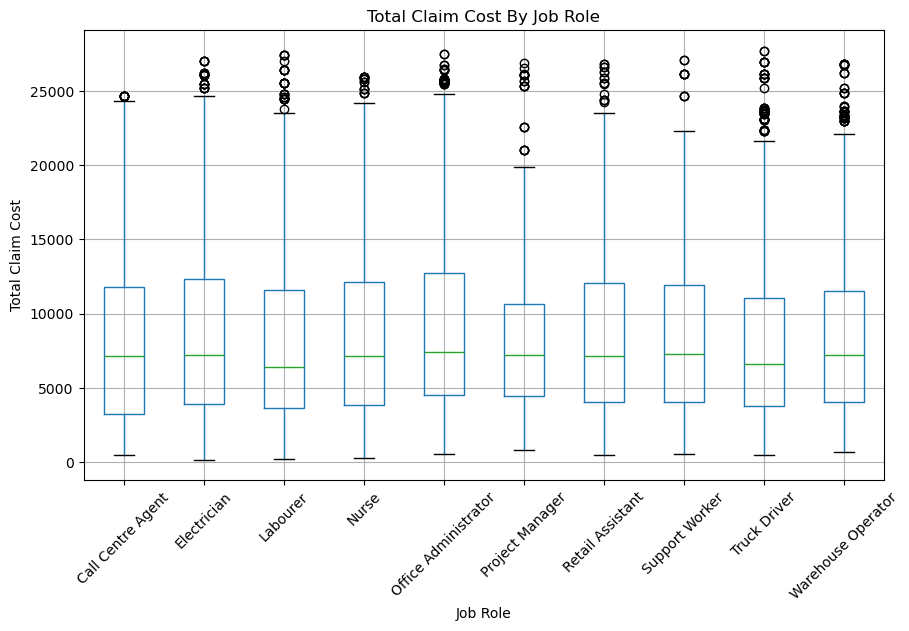

In [66]:
comp_billing_rtw. boxplot(
    column = 'total_claim_cost',
    by = 'job_role',
    rot = 45,
figsize = (10,6)
)

plt.title ("Total Claim Cost By Job Role")
plt.ylabel("Total Claim Cost")
plt.xlabel("Job Role")
plt.suptitle("")
plt.show()
           

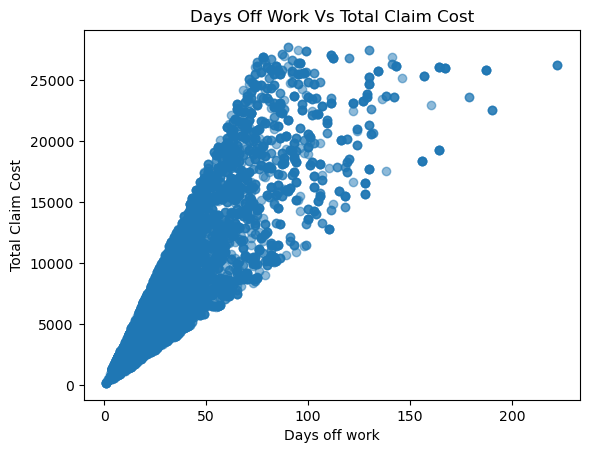

In [68]:
#plotting days off work vs total claims expense
import matplotlib.pyplot as plt

plt.scatter(comp_billing_rtw['days_off_work'], comp_billing_rtw['total_claim_cost'], alpha =0.5 )

plt.xlabel("Days off work")
plt.ylabel("Total Claim Cost")
plt.title("Days Off Work Vs Total Claim Cost")
plt.show()
#the graph shows positive correlation where total claim cost increased with increased days off, but hit a maximum payout of $27,000
#th fan shape indicates that while costs are predictable for the short absence they become more variable in with longer absence